# Лабораторная работа 7. Детекция объектов с помощью сверточных нейронных сетей

### Работу выполнил:<span style="color:blue"> {Иззатов Эльшан}</span>

** ССЫЛКА НА ВИДЕО ПОСЛЕДНЕЕ ЗАДАНИЕ**

https://drive.google.com/file/d/1XtJ4Bor3B_9sg6pQRGyoqiEAFrxY_HLE/view?usp=sharing

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/EqIJYrpQGKNAlYCYc9d54aUBmjBEhPTP3tn5ctj9Zfx5wA)

## Задание 1.
По [ссылке1](https://github.com/spmallick/learnopencv/tree/master/PyTorch-faster-RCNN) приведен пример детекции объектов сетью Faster R-CNN с использованием PyTorch.

По [ссылке2](https://pytorch.org/hub/ultralytics_yolov5/) приведен пример детекции объектов сетью YOLOv5 с использованием PyTorch.

Необходимо выполнить сравнение моделей детекции объектов Faster R-CNN ResNet-50 FPN, RetinaNet ResNet-50 FPN, YOLOv5 по следующим параметрам:
1. время инференса на GPU;
2. время инференса на CPU;
3. размер модели.

Результаты сравнения представить в виде диаграмм.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Устанавливаем необходимые зависимости
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T


class ModelComparator:
    def __init__(self):
        self.models = {}
        self.results = {}

    def load_models(self):
        """Загрузка всех моделей для сравнения с использованием актуального синтаксиса"""
        print("Загрузка моделей для сравнения...")

        # Faster R-CNN с использованием weights вместо pretrained
        self.models['faster_rcnn'] = torchvision.models.detection.fasterrcnn_resnet50_fpn(
            weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
        )

        # RetinaNet с использованием weights вместо pretrained
        self.models['retinanet'] = torchvision.models.detection.retinanet_resnet50_fpn(
            weights=torchvision.models.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1
        )

        # YOLOv5
        self.models['yolov5'] = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

        # Переводим все модели в eval mode
        for name in ['faster_rcnn', 'retinanet']:
            self.models[name].eval()

        print("Все модели успешно загружены!")

    def get_model_size(self, model):
        """Получение размера модели в MB"""
        torch.save(model.state_dict(), "temp.p")
        size = os.path.getsize("temp.p") / (1024 * 1024)  # в MB
        os.remove("temp.p")
        return size

    def measure_inference_time(self, image_path, device='cpu', num_runs=5):
        """Измерение времени инференса"""
        img = Image.open(image_path)
        transform = T.Compose([T.ToTensor()])
        img_tensor = transform(img)

        times = {}

        for model_name, model in self.models.items():
            print(f"Тестирование {model_name} на {device}...")

            try:
                # Подготовка модели и изображения
                if model_name != 'yolov5':
                    model = model.to(device)
                    img_device = img_tensor.to(device)
                else:
                    # YOLOv5 имеет свой формат ввода
                    model = model.to(device)
                    img_device = image_path

                # Прогрев
                if model_name != 'yolov5':
                    _ = model([img_device])
                else:
                    _ = model(img_device)

                # Измерение времени
                start_time = time.time()
                for _ in range(num_runs):
                    if model_name != 'yolov5':
                        _ = model([img_device])
                    else:
                        _ = model(img_device)
                end_time = time.time()

                avg_time = (end_time - start_time) / num_runs
                times[model_name] = avg_time

            except Exception as e:
                print(f"Ошибка при тестировании {model_name}: {e}")
                times[model_name] = float('inf')

        return times

    def compare_detection_models(self, test_image_path):
        """Сравнение моделей детекции по времени и размеру"""
        print("=== Сравнение моделей детекции объектов ===")

        # Проверяем существование файла
        if not os.path.exists(test_image_path):
            print(f"Ошибка: файл {test_image_path} не найден!")
            return None

        print(f"Используется тестовое изображение: {test_image_path}")

        # Размеры моделей
        print("\n--- Размеры моделей ---")
        model_sizes = {}
        for name, model in self.models.items():
            if name != 'yolov5':
                size = self.get_model_size(model)
                model_sizes[name] = size
                print(f"{name}: {size:.2f} MB")

        # Время на CPU
        print("\n--- Время инференса на CPU ---")
        cpu_times = self.measure_inference_time(test_image_path, device='cpu')
        for name, time_val in cpu_times.items():
            print(f"{name}: {time_val:.4f} сек")

        # Время на GPU (если доступно)
        gpu_times = {}
        if torch.cuda.is_available():
            print("\n--- Время инференса на GPU ---")
            gpu_times = self.measure_inference_time(test_image_path, device='cuda')
            for name, time_val in gpu_times.items():
                print(f"{name}: {time_val:.4f} сек")
        else:
            print("\nGPU не доступен для тестирования")

        # Сохранение результатов
        self.results = {
            'sizes': model_sizes,
            'cpu_times': cpu_times,
            'gpu_times': gpu_times
        }

        return self.results

    def plot_model_comparison(self):
        """Построение диаграмм сравнения моделей"""
        if not self.results:
            print("Сначала выполните compare_detection_models()")
            return

        # Создаем фигуру с подграфиками
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Сравнение моделей детекции объектов', fontsize=16, fontweight='bold')

        # Диаграмма 1: Размеры моделей
        sizes = self.results['sizes']
        models = list(sizes.keys())
        size_values = list(sizes.values())

        bars1 = axes[0, 0].bar(models, size_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
        axes[0, 0].set_title('Размеры моделей', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Размер (MB)', fontsize=12)
        axes[0, 0].grid(axis='y', alpha=0.3)

        # Добавляем значения на столбцы
        for bar, value in zip(bars1, size_values):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                           f'{value:.1f} MB', ha='center', va='bottom', fontweight='bold')

        # Диаграмма 2: Время на CPU
        cpu_times = self.results['cpu_times']
        cpu_models = list(cpu_times.keys())
        cpu_values = list(cpu_times.values())

        bars2 = axes[0, 1].bar(cpu_models, cpu_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
        axes[0, 1].set_title('Время инференса на CPU', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Время (сек)', fontsize=12)
        axes[0, 1].grid(axis='y', alpha=0.3)

        # Добавляем значения на столбцы
        for bar, value in zip(bars2, cpu_values):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f} с', ha='center', va='bottom', fontweight='bold')

        # Диаграмма 3: Время на GPU
        if self.results['gpu_times']:
            gpu_times = self.results['gpu_times']
            gpu_models = list(gpu_times.keys())
            gpu_values = list(gpu_times.values())

            bars3 = axes[1, 0].bar(gpu_models, gpu_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
            axes[1, 0].set_title('Время инференса на GPU', fontsize=14, fontweight='bold')
            axes[1, 0].set_ylabel('Время (сек)', fontsize=12)
            axes[1, 0].grid(axis='y', alpha=0.3)

            # Добавляем значения на столбцы
            for bar, value in zip(bars3, gpu_values):
                axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                               f'{value:.4f} с', ha='center', va='bottom', fontweight='bold')
        else:
            axes[1, 0].text(0.5, 0.5, 'GPU не доступен', ha='center', va='center',
                           transform=axes[1, 0].transAxes, fontsize=16)
            axes[1, 0].set_title('Время инференса на GPU', fontsize=14, fontweight='bold')

        # Диаграмма 4: Сравнение CPU vs GPU
        if self.results['gpu_times']:
            comparison_data = []
            labels = []
            for model in cpu_times.keys():
                if model in self.results['gpu_times']:
                    comparison_data.append([cpu_times[model], self.results['gpu_times'][model]])
                    labels.append(model)

            x = np.arange(len(labels))
            width = 0.35

            bars_cpu = axes[1, 1].bar(x - width/2, [data[0] for data in comparison_data],
                                     width, label='CPU', color='#FF6B6B', alpha=0.8)
            bars_gpu = axes[1, 1].bar(x + width/2, [data[1] for data in comparison_data],
                                     width, label='GPU', color='#4ECDC4', alpha=0.8)

            axes[1, 1].set_title('Сравнение CPU vs GPU', fontsize=14, fontweight='bold')
            axes[1, 1].set_ylabel('Время (сек)', fontsize=12)
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(labels)
            axes[1, 1].legend()
            axes[1, 1].grid(axis='y', alpha=0.3)

            # Добавляем значения на столбцы
            for bar, value in zip(bars_cpu, [data[0] for data in comparison_data]):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.3f} с', ha='center', va='bottom', fontsize=9, fontweight='bold')

            for bar, value in zip(bars_gpu, [data[1] for data in comparison_data]):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.4f} с', ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            axes[1, 1].text(0.5, 0.5, 'Нет данных GPU\nдля сравнения', ha='center', va='center',
                           transform=axes[1, 1].transAxes, fontsize=16)
            axes[1, 1].set_title('Сравнение CPU vs GPU', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

def run_model_comparison():
    """Запуск сравнения моделей детекции"""
    comparator = ModelComparator()
    comparator.load_models()

    # Используем тестовое изображение из Google Drive
    test_image_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg"

    print(f"Используется тестовое изображение из Google Drive: {test_image_path}")

    # Проверяем существование файла
    if not os.path.exists(test_image_path):
        print(f"Ошибка: файл {test_image_path} не найден!")
        print("Убедитесь, что Google Drive подключен и файл существует по указанному пути.")
        return None

    print("Начинаем сравнение моделей...")
    results = comparator.compare_detection_models(test_image_path)

    if results is None:
        return None

    # Строим диаграммы сравнения
    print("\nСтроим диаграммы сравнения...")
    comparator.plot_model_comparison()

    return results

results = run_model_comparison()

if results is not None:
    # Анализ результатов
    print("\n" + "="*50)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ СРАВНЕНИЯ")
    print("="*50)

    # Лучшая модель по скорости на CPU
    best_cpu_model = min(results['cpu_times'], key=results['cpu_times'].get)
    best_cpu_time = results['cpu_times'][best_cpu_model]
    print(f"Самая быстрая модель на CPU: {best_cpu_model} ({best_cpu_time:.4f} сек)")

    # Лучшая модель по скорости на GPU
    if results['gpu_times']:
        best_gpu_model = min(results['gpu_times'], key=results['gpu_times'].get)
        best_gpu_time = results['gpu_times'][best_gpu_model]
        print(f"Самая быстрая модель на GPU: {best_gpu_model} ({best_gpu_time:.4f} сек)")

        # Ускорение на GPU
        print("\nУскорение на GPU:")
        for model in results['gpu_times']:
            if model in results['cpu_times']:
                speedup = results['cpu_times'][model] / results['gpu_times'][model]
                print(f"  {model}: {speedup:.2f}x")

    # Самая компактная модель
    smallest_model = min(results['sizes'], key=results['sizes'].get)
    smallest_size = results['sizes'][smallest_model]
    print(f"\nСамая компактная модель: {smallest_model} ({smallest_size:.2f} MB)")

    # Сводная таблица
    print("\nСводная таблица результатов:")
    print("-" * 75)
    print(f"{'Модель':<15} {'Размер (MB)':<12} {'CPU время (с)':<15} {'GPU время (с)':<15}")
    print("-" * 75)

    for model in results['cpu_times'].keys():
        size = results['sizes'].get(model, "N/A")
        cpu_time = results['cpu_times'][model]
        gpu_time = results['gpu_times'].get(model, "N/A")

        if gpu_time != "N/A":
            gpu_str = f"{gpu_time:.4f}"
        else:
            gpu_str = "N/A"

        print(f"{model:<15} {str(size):<12} {cpu_time:<15.4f} {gpu_str:<15}")

    print("\n" + "=" * 60)
    print("Результаты сохранены в файле 'model_comparison.png'")
else:
    print("\n" + "=" * 60)
    print("Проверьте путь к тестовому изображению и подключение Google Drive")
results = run_model_comparison()

print("Результаты сохранены в файле 'model_comparison.png'")

Загрузка моделей для сравнения...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 131MB/s]


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


100%|██████████| 130M/130M [00:01<00:00, 130MB/s]
/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-11-1 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 248MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Все модели успешно загружены!
Используется тестовое изображение из Google Drive: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg
Начинаем сравнение моделей...
=== Сравнение моделей детекции объектов ===
Используется тестовое изображение: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg

--- Размеры моделей ---
faster_rcnn: 159.77 MB
retinanet: 130.24 MB

--- Время инференса на CPU ---
Тестирование faster_rcnn на cpu...
Тестирование retinanet на cpu...
Тестирование yolov5 на cpu...


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

faster_rcnn: 4.6737 сек
retinanet: 4.5084 сек
yolov5: 0.2755 сек

--- Время инференса на GPU ---
Тестирование faster_rcnn на cuda...
Тестирование retinanet на cuda...
Тестирование yolov5 на cuda...
faster_rcnn: 0.1102 сек
retinanet: 0.1078 сек
yolov5: 0.0201 сек

Строим диаграммы сравнения...


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am


АНАЛИЗ РЕЗУЛЬТАТОВ СРАВНЕНИЯ
Самая быстрая модель на CPU: yolov5 (0.2755 сек)
Самая быстрая модель на GPU: yolov5 (0.0201 сек)

Ускорение на GPU:
  faster_rcnn: 42.43x
  retinanet: 41.81x
  yolov5: 13.69x

Самая компактная модель: retinanet (130.24 MB)

Сводная таблица результатов:
---------------------------------------------------------------------------
Модель          Размер (MB)  CPU время (с)   GPU время (с)  
---------------------------------------------------------------------------
faster_rcnn     159.76755714416504 4.6737          0.1102         
retinanet       130.24311447143555 4.5084          0.1078         
yolov5          N/A          0.2755          0.0201         

Результаты сохранены в файле 'model_comparison.png'
Загрузка моделей для сравнения...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-1 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Все модели успешно загружены!
Используется тестовое изображение из Google Drive: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg
Начинаем сравнение моделей...
=== Сравнение моделей детекции объектов ===
Используется тестовое изображение: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg

--- Размеры моделей ---
faster_rcnn: 159.77 MB
retinanet: 130.24 MB

--- Время инференса на CPU ---
Тестирование faster_rcnn на cpu...
Тестирование retinanet на cpu...
Тестирование yolov5 на cpu...


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

faster_rcnn: 4.6645 сек
retinanet: 4.8785 сек
yolov5: 0.1914 сек

--- Время инференса на GPU ---
Тестирование faster_rcnn на cuda...
Тестирование retinanet на cuda...
Тестирование yolov5 на cuda...
faster_rcnn: 0.0993 сек
retinanet: 0.1109 сек
yolov5: 0.0204 сек

Строим диаграммы сравнения...


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

Результаты сохранены в файле 'model_comparison.png'


## Задание 2.
Выберите наиболее эффективную архетиктуру из рассмотренных в задании 1. Протестируйте данную архитектуру на задаче детекции птиц на фотографиях.
Протестируйте эту модель на нескольких изображениях (определять нужно только птиц).
Используйте данную модель для трекинга птиц на видео (в качестве детектора используйте нейросетевую модель, в качестве трекера - трекер MIL из OpenCV).

In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Загрузка предобученной модели YOLOv5 (YOLOv5s - самая быстрая и легкая)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Функция для детекции птиц на изображении
def detect_birds_image(image_path, confidence_threshold=0.5):
    """
    Детекция птиц на изображении с использованием YOLOv5
    """
    # Загрузка и детекция
    results = model(image_path)

    # Извлечение результатов в формате pandas
    detections = results.pandas().xyxy[0]

    # Фильтрация только птиц (class_id = 14 в COCO) с достаточной уверенностью
    bird_detections = detections[(detections['class'] == 14) &
                                (detections['confidence'] > confidence_threshold)]

    return bird_detections, results

# Функция для визуализации результатов детекции
def visualize_detection(image_path, detections, save_path=None):
    """
    Визуализация bounding boxes на изображении
    """
    # Загрузка изображения
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Отрисовка bounding boxes для каждого обнаружения
    for _, detection in detections.iterrows():
        x1, y1, x2, y2 = int(detection['xmin']), int(detection['ymin']), \
                         int(detection['xmax']), int(detection['ymax'])
        confidence = detection['confidence']

        # Рисование прямоугольника
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Добавление подписи с уверенностью
        label = f'Bird: {confidence:.2f}'
        cv2.putText(img, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Отображение результата
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Детекция птиц (найдено: {len(detections)})')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Основной код для детекции на изображении
def main_image_detection():
    # Путь к тестовому изображению из Google Drive
    test_image_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg"

    print("=== ДЕТЕКЦИЯ ПТИЦ НА ИЗОБРАЖЕНИИ ===")
    print(f"Тестовое изображение: {test_image_path}")

    # Детекция птиц
    bird_detections, results = detect_birds_image(test_image_path, confidence_threshold=0.5)

    # Вывод результатов
    print(f"Найдено птиц: {len(bird_detections)}")
    if len(bird_detections) > 0:
        print("\nДетали обнаружений:")
        for i, (_, detection) in enumerate(bird_detections.iterrows()):
            print(f"Птица {i+1}: confidence={detection['confidence']:.3f}, "
                  f"bbox=[{detection['xmin']:.1f}, {detection['ymin']:.1f}, "
                  f"{detection['xmax']:.1f}, {detection['ymax']:.1f}]")

    # Визуализация результатов
    visualize_detection(test_image_path, bird_detections, "bird_detection_result.jpg")

    return bird_detections, results

# Запуск детекции на изображении
image_detections, image_results = main_image_detection()


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-1 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


=== ДЕТЕКЦИЯ ПТИЦ НА ИЗОБРАЖЕНИИ ===
Тестовое изображение: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg
Найдено птиц: 3

Детали обнаружений:
Птица 1: confidence=0.921, bbox=[413.1, 290.2, 657.6, 415.3]
Птица 2: confidence=0.903, bbox=[186.1, 272.4, 365.8, 412.4]
Птица 3: confidence=0.511, bbox=[0.0, 351.8, 25.0, 441.0]


Используется устройство: cuda


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-1 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


=== ДЕТЕКЦИЯ И ТРЕКИНГ ПТИЦ НА ВИДЕО ===
Входное видео: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/video.avi
Выходное видео: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/bird_tracking_result.avi
Параметры видео: 1280x720, FPS: 25
Будет обработано: 4500 кадров (180 секунд)
Начало обработки видео...
Первый кадр с детекцией:


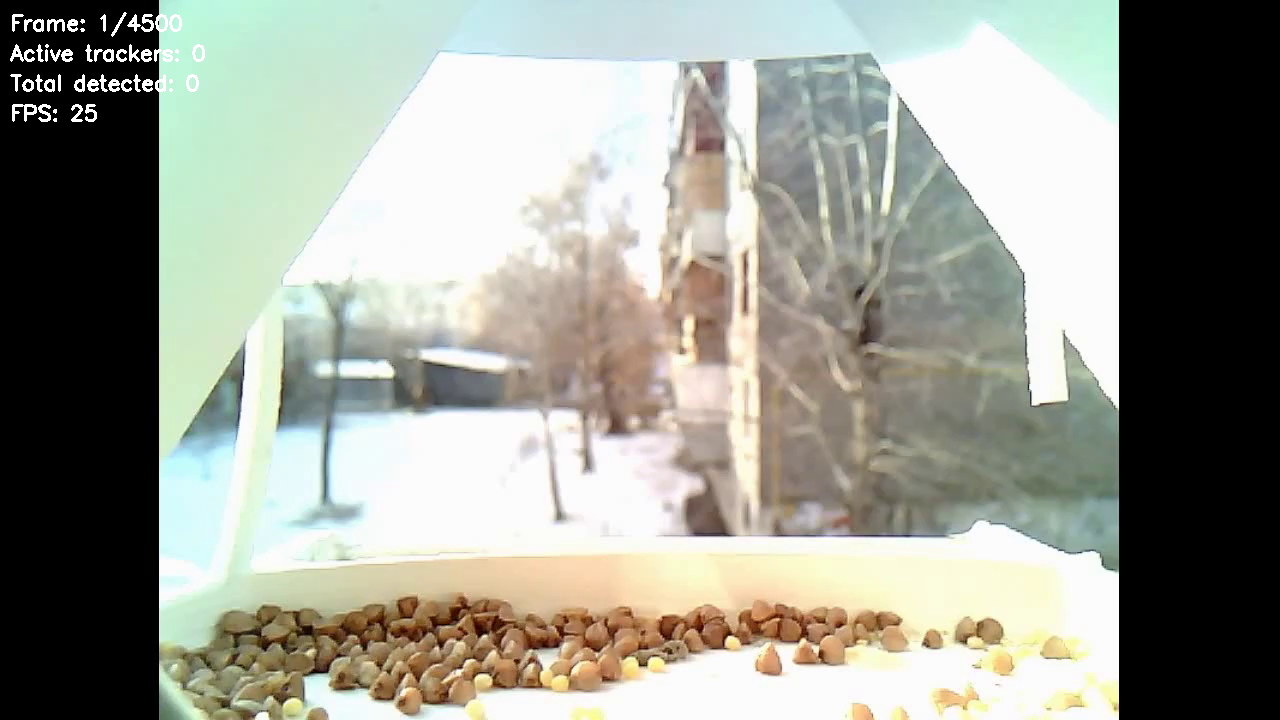

Обработано: 50/4500 (1.1%) | Скорость: 57.6 FPS | Осталось: 77.3 сек
Обработано: 100/4500 (2.2%) | Скорость: 76.4 FPS | Осталось: 57.6 сек
Обработано: 150/4500 (3.3%) | Скорость: 88.1 FPS | Осталось: 49.4 сек
Обработано: 200/4500 (4.4%) | Скорость: 94.3 FPS | Осталось: 45.6 сек
Обработано: 250/4500 (5.6%) | Скорость: 99.9 FPS | Осталось: 42.6 сек
Обработано: 300/4500 (6.7%) | Скорость: 103.7 FPS | Осталось: 40.5 сек
Обработано: 350/4500 (7.8%) | Скорость: 105.7 FPS | Осталось: 39.3 сек
Обработано: 400/4500 (8.9%) | Скорость: 108.2 FPS | Осталось: 37.9 сек
Обработано: 450/4500 (10.0%) | Скорость: 109.2 FPS | Осталось: 37.1 сек
Обработано: 500/4500 (11.1%) | Скорость: 108.5 FPS | Осталось: 36.9 сек
Обработано: 550/4500 (12.2%) | Скорость: 104.6 FPS | Осталось: 37.8 сек
Обработано: 600/4500 (13.3%) | Скорость: 101.9 FPS | Осталось: 38.3 сек
Обработано: 650/4500 (14.4%) | Скорость: 99.6 FPS | Осталось: 38.7 сек
Обработано: 700/4500 (15.6%) | Скорость: 98.0 FPS | Осталось: 38.8 сек
Обработа

In [5]:
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import time

# Проверяем доступность GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device}")

# Загрузка предобученной модели YOLOv5 на GPU
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to(device)
model.conf = 0.6  # Повышенный порог уверенности

# Подавляем warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def detect_birds_frame(frame, confidence_threshold=0.6):
    """
    Детекция птиц на отдельном кадре видео
    """
    # Конвертируем BGR в RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Детекция с YOLOv5
    results = model(frame_rgb, size=640)
    detections = results.pandas().xyxy[0]
    bird_detections = detections[(detections['class'] == 14) &
                                (detections['confidence'] > confidence_threshold)]

    # Конвертируем в формат для OpenCV трекера (x, y, w, h)
    bboxes = []
    confidences = []

    for _, detection in bird_detections.iterrows():
        x1, y1, x2, y2 = int(detection['xmin']), int(detection['ymin']), \
                         int(detection['xmax']), int(detection['ymax'])
        bboxes.append([x1, y1, x2-x1, y2-y1])
        confidences.append(detection['confidence'])

    return bboxes, confidences, bird_detections

def track_birds_video(video_path, output_path=None, max_duration=60, confidence_threshold=0.6):
    """
    Трекинг птиц на видео с ограничением длительности и улучшенным удалением трекеров
    """
    # Открываем видео
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Ошибка: Не удалось открыть видео {video_path}")
        return

    # Получаем параметры видео
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ограничиваем количество обрабатываемых кадров
    max_frames = min(total_frames, max_duration * fps)

    print(f"Параметры видео: {width}x{height}, FPS: {fps}")
    print(f"Будет обработано: {max_frames} кадров ({max_duration} секунд)")

    # Создаем VideoWriter для сохранения результата
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Словарь для хранения трекеров
    trackers = {}
    next_tracker_id = 0

    # Статистика
    frame_count = 0
    total_birds_detected = 0
    start_time = time.time()

    # Настройки
    detection_interval = 15  # Детекция каждые 15 кадров
    max_missed_frames = 10   # Максимальное количество кадров без обновления перед удалением трекера

    print("Начало обработки видео...")

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Показываем прогресс каждые 50 кадров
        if frame_count % 50 == 0:
            elapsed_time = time.time() - start_time
            fps_processed = frame_count / elapsed_time
            remaining_frames = max_frames - frame_count
            estimated_remaining = remaining_frames / fps_processed if fps_processed > 0 else 0
            print(f"Обработано: {frame_count}/{max_frames} ({frame_count/max_frames*100:.1f}%) | "
                  f"Скорость: {fps_processed:.1f} FPS | "
                  f"Осталось: {estimated_remaining:.1f} сек")

        # Обновляем существующие трекеры
        trackers_to_remove = []
        for tracker_id, tracker_info in trackers.items():
            tracker = tracker_info['tracker']
            success, bbox = tracker.update(frame)

            if success:
                # Трекер успешно обновился - сбрасываем счетчик пропущенных кадров
                x, y, w, h = [int(v) for v in bbox]
                trackers[tracker_id]['bbox'] = (x, y, w, h)
                trackers[tracker_id]['missed_frames'] = 0

                # Проверяем, не слишком ли маленький стал bounding box (птица могла улететь)
                if w < 10 or h < 10:
                    trackers[tracker_id]['missed_frames'] += 5  # Быстро удаляем маленькие bbox

                # Рисуем bounding box
                color = tracker_info['color']
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                cv2.putText(frame, f'Bird {tracker_id}', (x, y-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            else:
                # Увеличиваем счетчик пропущенных кадров
                trackers[tracker_id]['missed_frames'] += 1

                # Если трекер долго не обновляется, помечаем на удаление
                if trackers[tracker_id]['missed_frames'] > max_missed_frames:
                    trackers_to_remove.append(tracker_id)
                else:
                    # Временно рисуем bounding box с прозрачностью (пока не удален)
                    x, y, w, h = tracker_info['bbox']
                    alpha = 1.0 - (trackers[tracker_id]['missed_frames'] / max_missed_frames)
                    color = [int(c * alpha) for c in tracker_info['color']]
                    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                    cv2.putText(frame, f'Bird {tracker_id}', (x, y-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Удаляем трекеры, которые долго не обновлялись
        for tracker_id in trackers_to_remove:
            del trackers[tracker_id]
            print(f"Трекер {tracker_id} удален (потерян на {max_missed_frames} кадров)")

        # Периодическая детекция для добавления новых объектов
        if frame_count % detection_interval == 0:
            bboxes, confidences, _ = detect_birds_frame(frame, confidence_threshold)

            for bbox, confidence in zip(bboxes, confidences):
                x, y, w, h = bbox

                # Проверяем, не пересекается ли новая детекция с существующими трекерами
                overlap = False
                for tracker_info in trackers.values():
                    if tracker_info['missed_frames'] > 0:
                        continue  # Пропускаем трекеры, которые уже теряют объект

                    existing_bbox = tracker_info['bbox']
                    # Проверка пересечения по площади
                    ix1 = max(x, existing_bbox[0])
                    iy1 = max(y, existing_bbox[1])
                    ix2 = min(x + w, existing_bbox[0] + existing_bbox[2])
                    iy2 = min(y + h, existing_bbox[1] + existing_bbox[3])

                    intersection = max(0, ix2 - ix1) * max(0, iy2 - iy1)
                    area1 = w * h
                    area2 = existing_bbox[2] * existing_bbox[3]

                    if intersection > 0.3 * min(area1, area2):  # 30% перекрытия
                        overlap = True
                        break

                if not overlap and confidence > confidence_threshold:
                    # Создаем новый трекер
                    new_tracker = cv2.TrackerMIL_create()
                    new_tracker.init(frame, (x, y, w, h))

                    # Генерируем случайный цвет для трекера
                    color = tuple(np.random.randint(0, 255, 3).tolist())

                    trackers[next_tracker_id] = {
                        'tracker': new_tracker,
                        'bbox': (x, y, w, h),
                        'color': color,
                        'missed_frames': 0
                    }

                    print(f"Создан новый трекер {next_tracker_id} с confidence {confidence:.3f}")
                    next_tracker_id += 1
                    total_birds_detected += 1

        # Добавляем информацию о кадре
        cv2.putText(frame, f'Frame: {frame_count}/{max_frames}', (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f'Active trackers: {len([t for t in trackers.values() if t["missed_frames"] == 0])}', (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f'Total detected: {total_birds_detected}', (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f'FPS: {fps}', (10, 120),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Сохраняем кадр
        if output_path:
            out.write(frame)

        # Показываем первый кадр для демонстрации
        if frame_count == 1:
            print("Первый кадр с детекцией:")
            cv2_imshow(frame)

    # Освобождаем ресурсы
    cap.release()
    if output_path:
        out.release()

    total_time = time.time() - start_time
    print(f"\nОбработка завершена за {total_time:.1f} секунд")
    print(f"Обработано кадров: {frame_count}")
    print(f"Всего обнаружено уникальных птиц: {total_birds_detected}")
    print(f"Средняя скорость: {frame_count/total_time:.1f} FPS")

    return total_birds_detected

# Основной код для Colab
print("=== ДЕТЕКЦИЯ И ТРЕКИНГ ПТИЦ НА ВИДЕО ===")

# Путь к видео файлу в Google Drive
video_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/video.avi"
output_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/bird_tracking_result.avi"

print(f"Входное видео: {video_path}")
print(f"Выходное видео: {output_path}")

# Запуск трекинга с ограничением по времени
total_birds = track_birds_video(
    video_path=video_path,
    output_path=output_path,
    max_duration=180,  # Обрабатываем только первые 180 секунд
    confidence_threshold=0.6
)

print(f"\nРезультаты трекинга:")
print(f"Всего обнаружено уникальных птиц: {total_birds}")
print(f"Результат сохранен в: {output_path}")